# Evaluate Plots V2

test pair에 대한 iteration을 수행한다.

1. pickle을 통해서 모든 아이템을 다 읽는다.
2. 현재 source sequence를 읽는다.
3. scene similarity를 읽는다.
- mistral로 계산한 inclusion ratio
- 직접 계산한 entity similarity

4. action sequence similarity를 계산한다.
- agent4 필터 통과와 상관없이 플롯
- agent4 필터를 통과하면 플롯

5. activity taxnomy similarity를 계산한다.
- agent4 필터 통과와 상관없이 플롯
- agent4 필터를 통과하면 플롯


다음의 pandas colum을 구성한다. (568x13 정도 되나?)

없는 곳은 None표시를 한다.

source idx, target idx, 
augmentation_id, inclusion_ratio, entity_similarity
goal_category, goal_description
core activity_gt, core activity_inf
sequence sim, taxonomy sim
sequence bool, taxonomy bool

In [1]:
%matplotlib qt
import sys
import os
import numpy as np
import json
import torch
import matplotlib.pyplot as plt
import mplcursors
from sklearn.manifold import TSNE
from sentence_transformers import SentenceTransformer
from bert_score import score

import pickle

sys.path.append(os.path.abspath('/root/project')) # add root path to sys.path
sys.path.append(os.path.abspath('/usr/local/lib/python3.10/dist-packages'))
from util import util_constants
from util import util_funcs
import f4_evaluate.evaluate_scene as evaluate_scene
import f1_init.database_init as database_init
import f1_init.agent_init as agent_init
import f1_init.constants_init as constants_init

#Computing similarity
import json
from sentence_transformers import SentenceTransformer
from bert_score import score
import numpy as np
from numpy.linalg import norm
import ast
import pandas as pd

#PATHS
PATH_CURR_FOLDER = os.path.abspath('') 
PATH_DATA_ANNOTATION = os.path.abspath(os.path.join(PATH_CURR_FOLDER, '..', 'data_annotation'))
PATH_DATA_INPUT_OUTPUT = os.path.abspath(os.path.join(PATH_CURR_FOLDER, '..', 'data_input_output'))
PATH_SOURCE_TARGET_INPUT = os.path.abspath(os.path.join(PATH_CURR_FOLDER, '..', 'data_input_output/input/source_target_video_list.pkl'))
TEST_SPATIAL_ANNOTATION_PATH_MANUAL = PATH_DATA_ANNOTATION + '/spatial_testset/manual'

#PAIRSIM DATA
PATH_PAIRSIM = PATH_DATA_ANNOTATION + '/spatial_pairsim_result'

#AUGMENTED DATA PATH
TEST_SPATIAL_ANNOTATION_PATH_SEMI = PATH_DATA_ANNOTATION + '/spatial_testset/semi'    
TEST_SPATIAL_ANNOTATION_V2_PATH = PATH_DATA_ANNOTATION + '/spatial_augmentation/TESTSET_Augmented_Data_v2/'

#BASELINE RESULT PATHS
PATH_BASELINE_RAG = os.path.abspath(os.path.join(PATH_CURR_FOLDER, '..', 'data_input_output/output-rag/'))
PATH_BASELINE_NORAG = os.path.abspath(os.path.join(PATH_CURR_FOLDER, '..', 'data_input_output/output-norag/'))
PATH_BASELINE_1DIRECT = os.path.abspath(os.path.join(PATH_CURR_FOLDER, '..', 'data_input_output/output-1direct/'))
PATH_BASELINE_1GOALMEDIATION = os.path.abspath(os.path.join(PATH_CURR_FOLDER, '..', 'data_input_output/output-1goalmediation/'))




QStandardPaths: XDG_RUNTIME_DIR not set, defaulting to '/tmp/runtime-root'


/root/project/data/ego4d_annotation/goalstep/
all: goalstep vids: 717
all: spatial vids: 211
dbinit: testuid excluded: goalstep vids: 646
dbinit: testuid excluded: spatial vids: 140
dbinit: testuid list: test goalstep vids: 71
dbinit: testuid list: test spatial vids: 71
dbinit: MAKE_DOCU: goalstep_document_list: 38613
dbinit: MAKE_DOCU: goalstep_document_list: 1366
dbinit: MAKE_DOCU: spatial_document_list: 1243
dbinit: MAKE_DOCUAKE: spatial_document_list: 752
LOAD FAISS GOALSTEP: /root/project/data/ego4d_annotation/goalstep_docarray_faiss
LOAD FAISS SPATIAL: /root/project/data/ego4d_annotation/spatial_docarray_faiss


In [2]:
def load_file(path):
    try:          
         with open(path, "rb") as f:
             data = pickle.load(f)
             return data
    except:
         return None
    
#=====================================
# SIMILARITIES
#=====================================
def cosine_similarity(vec1, vec2):
    vec1 = np.array(vec1)
    vec2 = np.array(vec2)
    if norm(vec1) == 0 or norm(vec2) == 0:
        return 0.0
    return np.dot(vec1, vec2) / (norm(vec1) * norm(vec2))

def safe_parse_sequence(seq):
    if seq is None:
        return []
    if isinstance(seq, list):
        return seq
    try:
        return ast.literal_eval(seq)
    except (ValueError, SyntaxError):
        return []

def safe_parse_taxonomy(tax):
    if tax is None:
        return {}
    if isinstance(tax, dict):
        return tax
    try:
        return json.loads(tax)
    except (json.JSONDecodeError, TypeError):
        return {}

def compute_similarities(entry, embed_model):
    # --- Parse sequences ---
    source_seq = safe_parse_sequence(entry.get('source_sequence'))
    target_seq = safe_parse_sequence(entry.get('target_sequence'))

    if not source_seq or not target_seq:
        seq_similarity = 0.0
    else:
        source_seq_str = ' '.join(source_seq)
        target_seq_str = ' '.join(target_seq)
        source_seq_emb = embed_model.encode(source_seq_str)
        target_seq_emb = embed_model.encode(target_seq_str)
        seq_similarity = cosine_similarity(source_seq_emb, target_seq_emb)

    # --- Parse taxonomies ---
    source_tax = safe_parse_taxonomy(entry.get('source_taxnomy'))
    target_tax = safe_parse_taxonomy(entry.get('target_taxonomy'))

    if not source_tax or not target_tax:
        tax_similarity = 0.0
    else:
        source_tax_str = ' '.join(f"{k}: {v}" for k, v in source_tax.items())
        target_tax_str = ' '.join(f"{k}: {v}" for k, v in target_tax.items())
        source_tax_emb = embed_model.encode(source_tax_str)
        target_tax_emb = embed_model.encode(target_tax_str)
        tax_similarity = cosine_similarity(source_tax_emb, target_tax_emb)

    return seq_similarity, tax_similarity

## Read Results

read a list of 568 pickle sets in 8 elements for 8 levels in augmentation

make dictionary
-fill every information
-fill every calculatable information
-save as df

In [18]:

source_list = [] # [0,0,0,0,1,1,1,1,...,283] -> [0,1,2,3,..71,0,1,2,3,4..71,...71]
target_list = [] # [augno_0: 55, aug33_0: 33,aug67_0: 28,aug100_0: 22,...] -> [55,26,22,...]
baselines = ["rag","norag","1direct","1goalmediation"]
sbert_model = SentenceTransformer('all-MiniLM-L6-v2')


def make_singlebaseline_list(baseline_result_path:str, baseline:str):
    '''
    func: make single baseline list

    '''
    baseline_result_path = baseline_result_path + "/"
    baseline_results = []
    augmodes = [30, 40, 50, 60, 70, 80, 90, 100]
    length = 71 * 8 #8levels, 8files

    for i in range(length):
    # for i in range(568):
        # print(i)
        dict = {
            "source_idx":None, "target_idx":None, "source_uid": None, "baseline": None, "augmode": None, 
            "source_sequence": None, "source_scene_graph": None, "target_scene_graph": None, 
            "core_activity": None, "source_taxonomy": None, "common_taxonomy": None, 
            "target_taxonomy": None, "target_sequence": None, 
            "sequence_boolean": None, "taxonomy_boolean": None, 
            "inclusion_ratio":None, #"pairwise_similarity": None,
            #"sequence_similarity_sbert": None, "taxonomy_similarity_sbert":None
            }

        prefix = f"pair{i}_"
        augmode = i%len(augmodes)
        # FILL RAW DATA
        sourceinfo_dict = load_file(baseline_result_path + prefix + "sourceinfo.pkl")
        targetinfo_dict = load_file(baseline_result_path + prefix + "targetinfo.pkl")
        dict["source_idx"] = sourceinfo_dict['source_idx']
        dict["target_idx"] = targetinfo_dict['target_idx']
        dict["source_uid"] = sourceinfo_dict['source_uid']
        dict["baseline"] = baseline
        dict["augmode"] = augmode


        dict['source_sequence'] =sourceinfo_dict['source_action_sequence']
        dict['source_sequence'] = dict['source_sequence'].strip('"').split(', ') #make into list

        dict['source_scene_graph'] =sourceinfo_dict['source_scene_graph']
        dict['target_scene_graph'] =targetinfo_dict['target_scene_graph']

        dict['core_activity'] =load_file(baseline_result_path + prefix + "agent1a.pkl")
        dict['source_taxonomy'] =load_file(baseline_result_path + prefix + "agent1b.pkl")
        dict['common_taxonomy'] =load_file(baseline_result_path + prefix + "agent2a.pkl")
        dict['target_taxonomy'] =load_file(baseline_result_path + prefix + "agent2b.pkl")
        dict['target_sequence'] =load_file(baseline_result_path + prefix + "agent3.pkl")

        booleans= load_file(baseline_result_path+prefix+"agent4.pkl")
        if(booleans == None):
            dict["sequence_boolean"] = False
            dict["taxonomy_boolean"] = False 
        else:
            values = [
                line.split(":")[1].strip()
                for line in booleans.strip().splitlines()
                if ":" in line
            ]
            # print(values[1])
            dict["taxonomy"] = True if values[0] == 'yes' else False
            dict["sequence_boolean"] = True if values[1] == 'yes' else False
            # print(dict["sequence_boolean"])
        
        dict['inclusion_ratio'] = sourceinfo_dict['spatial_similarity']
        #dict['pairwise_similarity'] = compare_scene_graph(dict['source_scene_graph'], dict['target_scene_graph'])

        # CALCULATE SIMILARITY DATA (SBERT, BERTSCORE)
        # SBERT for block level semantics

        if dict['target_sequence'] != None:
            dict['target_sequence'] = ast.literal_eval(dict['target_sequence'])
            dict['target_sequence'] = [", ".join(dict['target_sequence'])] # to single item
            dict['source_sequence'] = [", ".join(dict['source_sequence'])]# to single item
            
            sequence_similarity_sbert, taxonomy_similarity_sbert = compute_similarities(dict, sbert_model)
            dict["sequence_similarity_sbert"]= sequence_similarity_sbert
            dict["taxonomy_similarity_sbert"]= taxonomy_similarity_sbert

            # BERTSCORE for little more stepwise precision in similarity measurement
            # print(len(dict['target_sequence']))
            # print(len(dict['source_sequence']))
            # print(dict['target_sequence'])
            # print(dict['source_sequence'])# not inside bracket
            # print(dict['target_taxonomy'])
            # print(dict['source_taxonomy'])

            #takes very long
            # dict["sequence_b_P"], dict["sequence_b_R"], dict["sequence_b_F1"] = score(dict['target_sequence'], dict['source_sequence'], lang="en", rescale_with_baseline=True)

            #This part gives trouble
            # dict["taxonomy_b_P"], dict["taxonomy_b_R"], dict["taxonomy_b_F1"] =score(dict['target_taxonomy'], dict['source_taxonomy'], lang="en", rescale_with_baseline=True)
        baseline_results.append(dict)
    return baseline_results

baseline_rag_list = make_singlebaseline_list(PATH_BASELINE_RAG, baselines[0])
baseline_norag_list = make_singlebaseline_list(PATH_BASELINE_NORAG, baselines[1])
baseline_1direct_list = make_singlebaseline_list(PATH_BASELINE_1DIRECT, baselines[2])
baseline_1goalmediation_list = make_singlebaseline_list(PATH_BASELINE_1GOALMEDIATION, baselines[3])

print(len(baseline_rag_list))
print(len(baseline_norag_list))
print(len(baseline_1direct_list))
print(len(baseline_1goalmediation_list))


568
568
568
568


## Perform Numerical Calculation of Results

### base results
- pairwise scene similarity
- seq2seq similarity
- seq2seq taxonomy similarity
### plot
- per scenario similarity analysis
- per augmentation, per scenario similarity analysis
- per scenario similarity vs similarity



In [25]:

def mask_nan_df(df):
    mask = df.isna().any(axis=1)
    df.loc[mask, :] = np.nan 
    
def mask_nan_df_or_condition(df, columns_to_check):
    '''
    input: columns_to_check = ["col1", "col2"]
    '''
    mask = df[columns_to_check].isna().any(axis=1)
    df.loc[mask, :] = np.nan    

def save_baseline_list(path, baseline_list):
    with open(path, 'wb') as f:
        pickle.dump(baseline_list, f)
        print(f"saved baseline list at {path}")

# turn list of dictionary into dataframe
# df_rag = pd.DataFrame(baseline_rag_list)


df_rag = pd.DataFrame(baseline_rag_list)
mask_nan_df_or_condition(df_rag, ["target_taxonomy","target_sequence"])

df_norag = pd.DataFrame(baseline_norag_list)
mask_nan_df_or_condition(df_norag, ["target_taxonomy","target_sequence"])

df_1direct = pd.DataFrame(baseline_1direct_list)
mask_nan_df_or_condition(df_1direct, ["target_sequence"])
# print(df_1direct.head())

df_1goalmediation = pd.DataFrame(baseline_1goalmediation_list)
mask_nan_df_or_condition(df_1goalmediation, ["target_sequence"])
# print(df_1goalmediation.head())


baseline_rag_path = 'evaluation_result_v4/rag_dict.pkl'
baseline_norag_path = 'evaluation_result_v4/norag_dict.pkl'
baseline_1direct_path = 'evaluation_result_v4/1direct_dict.pkl'
baseline_1goalmediation_list_path = 'evaluation_result_v4/1goalmediation_dict.pkl'

save_baseline_list(baseline_rag_path, baseline_rag_list)
save_baseline_list(baseline_norag_path, baseline_norag_list)
save_baseline_list(baseline_1direct_path, baseline_1direct_list)
save_baseline_list(baseline_1goalmediation_list_path, baseline_1goalmediation_list)


print(df_rag.shape[0])
print(df_norag.shape[0])
print(df_1direct.shape[0])
print(df_1goalmediation.shape[0])





saved baseline list at evaluation_result_v4/rag_dict.pkl
saved baseline list at evaluation_result_v4/norag_dict.pkl
saved baseline list at evaluation_result_v4/1direct_dict.pkl
saved baseline list at evaluation_result_v4/1goalmediation_dict.pkl
568
568
568
568


/tmp/ipykernel_3729869/178733275.py:10: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'nan' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  df.loc[mask, :] = np.nan
/tmp/ipykernel_3729869/178733275.py:10: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'nan' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  df.loc[mask, :] = np.nan
/tmp/ipykernel_3729869/178733275.py:10: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'nan' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  df.loc[mask, :] = np.nan
/tmp/ipykernel_3729869/178733275.py:10: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a fut

0


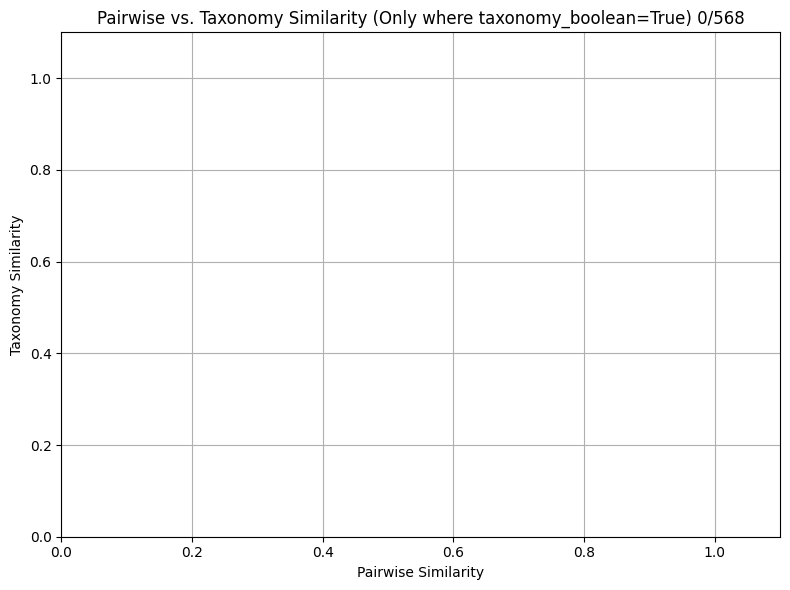

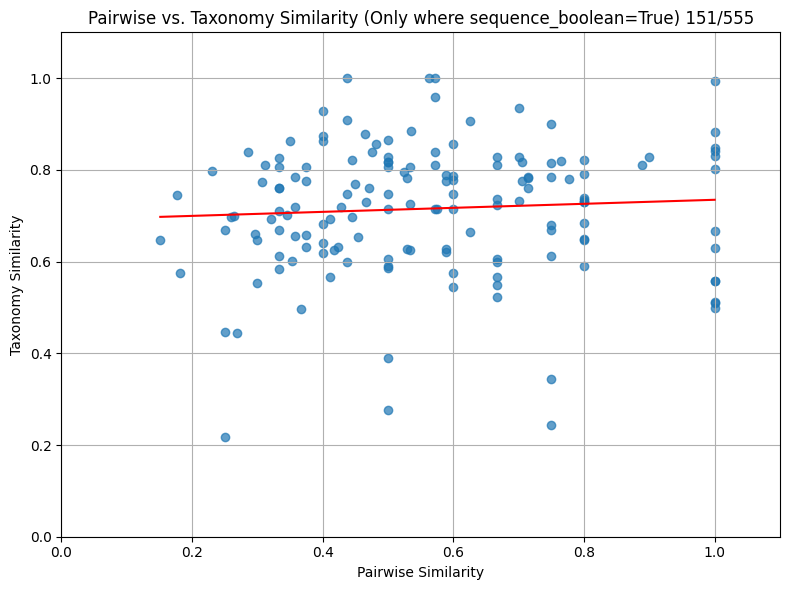

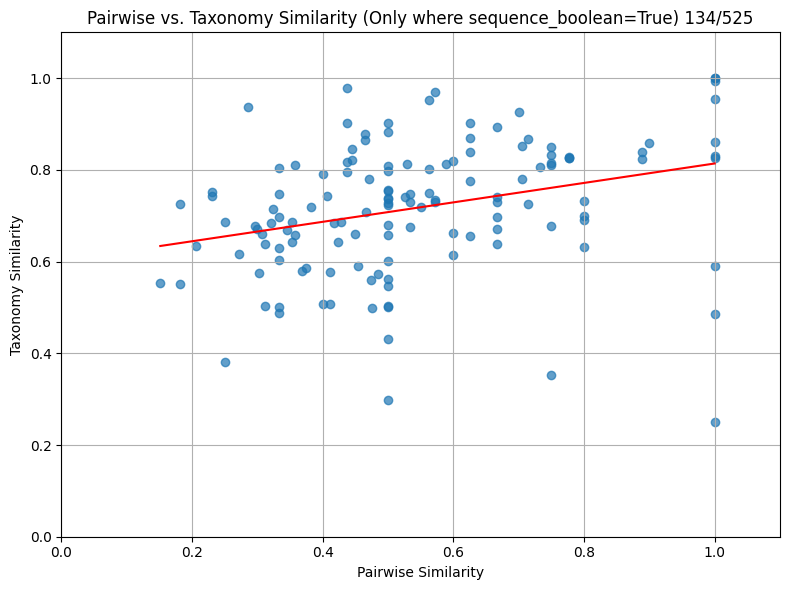

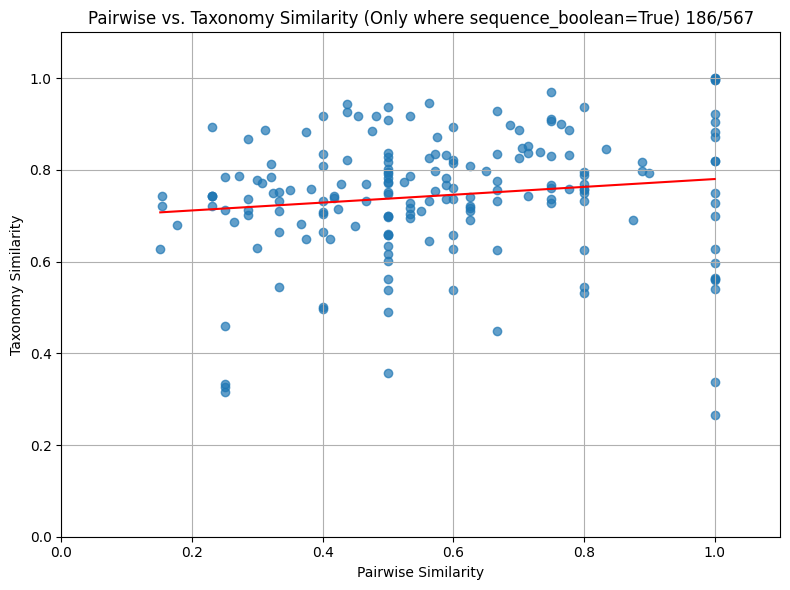

In [ ]:

import pandas as pd
import matplotlib.pyplot as plt

# Assume df is your DataFrame

# Step 1: Filter where taxonomy_boolean is True
def plot_taxonomy(df):
    size1 = df.shape[0]
    # df = df.dropna()
    mybool = True
    filtered_df = df[df['taxonomy_boolean'] == mybool]
    size2 = filtered_df.shape[0]
    print(filtered_df.shape[0])
    # Step 2: Plot
    plt.figure(figsize=(8, 6))
    plt.scatter(filtered_df['inclusion_ratio'], filtered_df['taxonomy_similarity_sbert'], alpha=0.7)
    plt.xlabel('Pairwise Similarity')
    plt.ylabel('Taxonomy Similarity')
    plt.title(f'Pairwise vs. Taxonomy Similarity (Only where taxonomy_boolean={mybool}) {size2}/{size1}')


    #Generate smooth x values for curve plotting
    N=1
    coeffs = np.polyfit(filtered_df['inclusion_ratio'], filtered_df['taxonomy_similarity_sbert'], deg=N)
    poly_func = np.poly1d(coeffs)
    x_smooth = np.linspace(filtered_df['inclusion_ratio'].min(), filtered_df['inclusion_ratio'].max(), 200)
    y_smooth = poly_func(x_smooth)
    plt.plot(x_smooth, y_smooth, color='red', label=f'{N}° polynomial fit')


    plt.xlim(0, 1.1)
    plt.ylim(0, 1.1)  

    plt.grid(True)
    plt.tight_layout()
    plt.show()


def plot_taxonomy_cursor(df):
    size1 = df.shape[0]
    mybool = True
    filtered_df = df[df['taxonomy_boolean'] == mybool]
    size2 = filtered_df.shape[0]
    print(filtered_df.shape[0])

    # Step 2: Plot
    fig, ax = plt.subplots(figsize=(8, 6))
    sc = ax.scatter(
        filtered_df['inclusion_ratio'], 
        filtered_df['taxonomy_similarity_sbert'], 
        alpha=0.7
    )

    ax.set_xlabel('Pairwise Similarity')
    ax.set_ylabel('Taxonomy Similarity')
    ax.set_title(f'Pairwise vs. Taxonomy Similarity (Only where taxonomy_boolean={mybool}) {size2}/{size1}')

    # # Polynomial fit
    # N = 1
    # coeffs = np.polyfit(filtered_df['inclusion_ratio'], filtered_df['taxonomy_similarity_sbert'], deg=N)
    # poly_func = np.poly1d(coeffs)
    # x_smooth = np.linspace(filtered_df['inclusion_ratio'].min(), filtered_df['inclusion_ratio'].max(), 200)
    # y_smooth = poly_func(x_smooth)
    # ax.plot(x_smooth, y_smooth, color='red', label=f'{N}° polynomial fit')

    # Limits and layout
    ax.set_xlim(0, 1.1)
    ax.set_ylim(0, 1.1)
    ax.grid(True)
    plt.tight_layout()

    # mplcursors for interactive tooltips
    cursor = mplcursors.cursor(sc, hover=True)
    
    @cursor.connect("add")
    def on_add(sel):
        idx = sel.index
        # Customize the tooltip content here
        sel.annotation.set_text(
            f"x: {filtered_df['inclusion_ratio'].iloc[idx]:.2f}\n"
            f"y: {filtered_df['taxonomy_similarity_sbert'].iloc[idx]:.2f}\n"
            f"info: {filtered_df.get('source_uid', pd.Series(['N/A'] * size2)).iloc[idx]}"
        )

    plt.show()    


def plot_sequence(df):
    df = df.dropna(subset=['inclusion_ratio', 'sequence_similarity_sbert', 'sequence_boolean'])
    size1 = df.shape[0]
    mybool = True
    filtered_df = df[df['sequence_boolean'] == mybool]
    size2 = filtered_df.shape[0]

    # filtered_df = df

    # Step 2: Plot
    plt.figure(figsize=(8, 6))
    plt.scatter(filtered_df['inclusion_ratio'], filtered_df['sequence_similarity_sbert'], alpha=0.7)
    plt.xlabel('Pairwise Similarity')
    plt.ylabel('Sequence Similarity')
    plt.title(f'2Pairwise vs. Sequence Similarity (Only where sequence_boolean={mybool} {size2}/{size1})')

    # Generate smooth x values for curve plotting
    N=1
    coeffs = np.polyfit(filtered_df['inclusion_ratio'], filtered_df['sequence_similarity_sbert'], deg=N)
    poly_func = np.poly1d(coeffs)
    x_smooth = np.linspace(filtered_df['inclusion_ratio'].min(), filtered_df['inclusion_ratio'].max(), 200)
    y_smooth = poly_func(x_smooth)
    plt.plot(x_smooth, y_smooth, color='red', label=f'{N}° polynomial fit')

    plt.xlim(0, 1.1)
    plt.ylim(0, 1.1)  

    plt.grid(True)
    plt.tight_layout()
    plt.show()    


def plot_sequence_cursor(df):
    df = df.dropna(subset=['inclusion_ratio', 'sequence_similarity_sbert', 'sequence_boolean'])
    mybool = True
    filtered_df = df[df['sequence_boolean'] == mybool]
    size1 = df.shape[0]
    size2 = filtered_df.shape[0]

    # Step 2: Plot
    fig, ax = plt.subplots(figsize=(8, 6))
    sc = ax.scatter(
        filtered_df['inclusion_ratio'], 
        filtered_df['sequence_similarity_sbert'], 
        alpha=0.7
    )

    ax.set_xlabel('Pairwise Similarity')
    ax.set_ylabel('Taxonomy Similarity')
    ax.set_title(f'Pairwise vs. Taxonomy Similarity (Only where sequence_boolean={mybool}) {size2}/{size1}')

    # Polynomial fit
    N = 1
    coeffs = np.polyfit(filtered_df['inclusion_ratio'], filtered_df['sequence_similarity_sbert'], deg=N)
    poly_func = np.poly1d(coeffs)
    x_smooth = np.linspace(filtered_df['inclusion_ratio'].min(), filtered_df['inclusion_ratio'].max(), 200)
    y_smooth = poly_func(x_smooth)
    ax.plot(x_smooth, y_smooth, color='red', label=f'{N}° polynomial fit')

    # Limits and layout
    ax.set_xlim(0, 1.1)
    ax.set_ylim(0, 1.1)
    ax.grid(True)
    plt.tight_layout()

    # mplcursors for interactive tooltips
    cursor = mplcursors.cursor(sc, hover=True)
    
    @cursor.connect("add")
    def on_add(sel):
        idx = sel.index
        # Customize the tooltip content here
        sel.annotation.set_text(
            f"x: {filtered_df['inclusion_ratio'].iloc[idx]:.2f}\n"
            f"y: {filtered_df['sequence_similarity_sbert'].iloc[idx]:.2f}\n"
            f"info: {filtered_df.get('source_uid', pd.Series(['N/A'] * size2)).iloc[idx]}"
        )
 

    plt.show()    



# plot_taxonomy(df_rag)
# plot_taxonomy(df_norag)
plot_taxonomy_cursor(df_norag)


plot_sequence_cursor(df_rag)
plot_sequence_cursor(df_norag)
# plot_sequence_cursor(df_1direct)
plot_sequence_cursor(df_1goalmediation)


In [11]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import mplcursors

# Dummy DataFrame
df = pd.DataFrame({
    'inclusion_ratio': np.random.rand(10),
    'sequence_similarity_sbert': np.random.rand(10),
    'taxonomy_boolean': [True] * 10,
    'source_uid': [f"Item {i}" for i in range(40, 50)]
})

plot_sequence_cursor(df)

KeyError: ['sequence_boolean']